In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors

import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

import torch
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

from nflows.flows import MaskedAutoregressiveFlow

In [2]:
data = pd.read_csv("../data/preprocessed/heloc.csv")

In [3]:
Xs = torch.from_numpy(data.to_numpy(dtype=np.float32)[:, :-1])
ys = torch.from_numpy(data.to_numpy(dtype=np.float32)[:, -1])
print(Xs.shape, ys.shape)

X_train, X_test, y_train, y_test = train_test_split(Xs, ys, test_size=0.3, shuffle=True, random_state=42)

# Create a DataLoader for the TensorDataset
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=128, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=128, shuffle=True)

torch.Size([10459, 23]) torch.Size([10459])


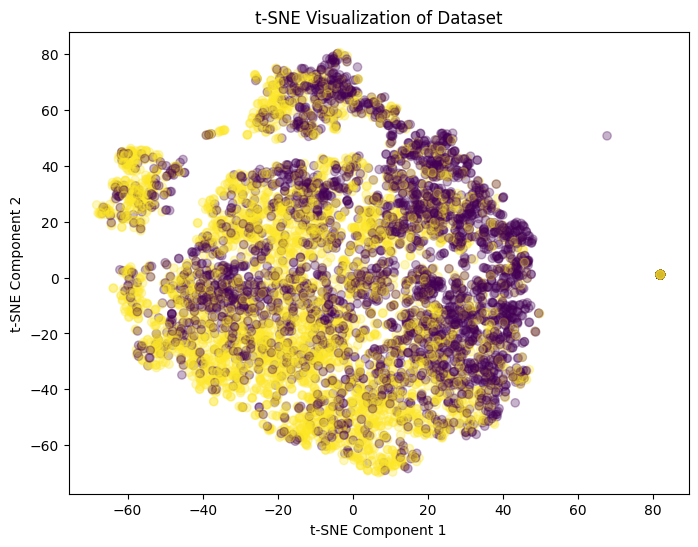

In [7]:
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_train)

plt.figure(figsize=(8, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_train, alpha=0.3)
plt.title('t-SNE Visualization of Dataset')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

In [8]:
from umap import UMAP

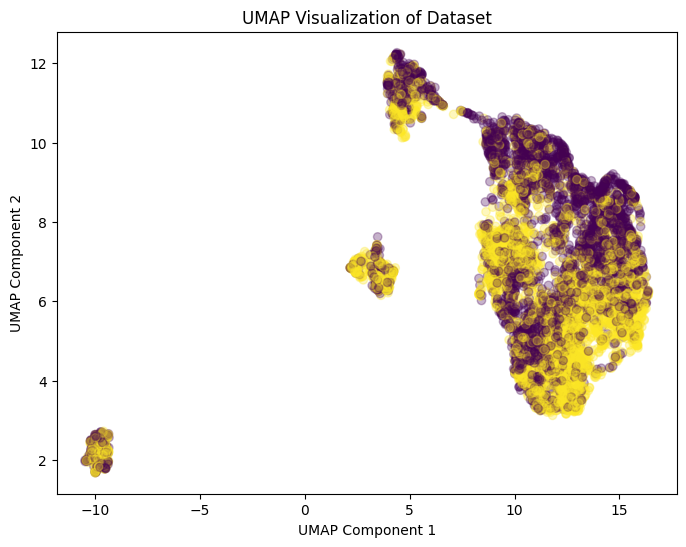

In [12]:
X_umap = UMAP().fit_transform(X_train)
plt.figure(figsize=(8, 6))
plt.scatter(X_umap[:, 0], X_umap[:, 1], c=y_train, alpha=0.3)
plt.title('UMAP Visualization of Dataset')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.show()

In [13]:
flow = MaskedAutoregressiveFlow(features=23, hidden_features=4, context_features=1)
optimizer = optim.RAdam(flow.parameters(), lr=0.001)

# Baseline

In [23]:
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train, y_train)
rf_predictions = rf_classifier.predict(X_test)

# Support Vector Machine (SVM) Classifier
svm_classifier = SVC(kernel='linear', random_state=42)
svm_classifier.fit(X_train, y_train)
svm_predictions = svm_classifier.predict(X_test)

# Logistic Regression Classifier
lr_classifier = LogisticRegression(random_state=42)
lr_classifier.fit(X_train, y_train)
lr_predictions = lr_classifier.predict(X_test)

# Evaluate the models
rf_accuracy = accuracy_score(y_test, rf_predictions)
svm_accuracy = accuracy_score(y_test, svm_predictions)
lr_accuracy = accuracy_score(y_test, lr_predictions)

print("Random Forest Classifier Accuracy:", rf_accuracy)
print("SVM Classifier Accuracy:", svm_accuracy)
print("Logistic Regression Classifier Accuracy:", lr_accuracy)

# # Classification Reports
# print("\nClassification Report for Random Forest:")
# print(classification_report(y_test, rf_predictions))

# print("\nClassification Report for SVM:")
# print(classification_report(y_test, svm_predictions))

print("\nClassification Report for Logistic Regression:")
print(classification_report(y_test, lr_predictions))

Random Forest Classifier Accuracy: 0.7029955385595921
SVM Classifier Accuracy: 0.7052262587635436
Logistic Regression Classifier Accuracy: 0.7029955385595921

Classification Report for Logistic Regression:
              precision    recall  f1-score   support

         0.0       0.70      0.66      0.68      1489
         1.0       0.71      0.75      0.73      1649

    accuracy                           0.70      3138
   macro avg       0.70      0.70      0.70      3138
weighted avg       0.70      0.70      0.70      3138



In [ ]:
# check models from CARLA

# MAF Accuracy

In [14]:
num_epochs = 150
for i in tqdm(range(num_epochs), desc="Epochs: "):
    train_losses = []
    test_losses = []
    for x, y in train_loader:
        y = y.reshape(-1, 1)
        optimizer.zero_grad()
        loss = -flow.log_prob(inputs=x, context=y).mean()
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    for x, y in train_loader:
        with torch.no_grad():
            y = y.reshape(-1, 1)
            loss = -flow.log_prob(inputs=x, context=y).mean()
            test_losses.append(loss.item())
    if i % 10 == 0:
        print(f"Epoch {i}, Train: {np.mean(train_losses)}, test: {np.mean(test_losses)}")

Epochs:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 0, Train: 67.07926888301455, test: 65.83188708075161
Epoch 10, Train: 25.83475241167792, test: 25.365950419985015
Epoch 20, Train: 21.345781655147157, test: 21.231374970797834
Epoch 30, Train: 19.640002579524598, test: 19.54359143355797
Epoch 40, Train: 18.695564434446137, test: 18.664281549124883
Epoch 50, Train: 17.83042486782732, test: 17.66862782116594
Epoch 60, Train: 16.805956560989905, test: 16.598576611485974
Epoch 70, Train: 15.578407271154996, test: 15.333339477407522
Epoch 80, Train: 15.24896763110983, test: 14.892553608993005
Epoch 90, Train: 15.649141969351932, test: 15.37206584009631
Epoch 100, Train: 16.00513377682916, test: 15.153881467621902
Epoch 110, Train: 19.085707845359014, test: 17.215536512177565
Epoch 120, Train: 14.658238805573562, test: 14.217882008388125
Epoch 130, Train: 15.226232018964044, test: 14.333474751176505
Epoch 140, Train: 15.390315466913684, test: 18.780566675909633


In [30]:
X_test.shape

torch.Size([3138, 23])

In [41]:
with torch.no_grad():
    nll_context_zero = flow.log_prob(X_test, context=torch.zeros((X_test.shape[0], 1)))
    nll_context_one = flow.log_prob(X_test, context=torch.ones((X_test.shape[0], 1)))


maf_predictions = np.zeros_like(nll_context_one)
maf_predictions[nll_context_one > nll_context_zero] = 1
print(classification_report(y_test, maf_predictions))

              precision    recall  f1-score   support

         0.0       0.57      0.71      0.63      1489
         1.0       0.66      0.51      0.58      1649

    accuracy                           0.61      3138
   macro avg       0.62      0.61      0.60      3138
weighted avg       0.62      0.61      0.60      3138



In [27]:
N = 1024
with torch.no_grad():
    samples_zero, log_probs = flow.sample_and_log_prob(N, context=torch.Tensor([[0]]))
    samples_one, log_probs = flow.sample_and_log_prob(N, context=torch.Tensor([[1]]))

samples_zero = samples_zero.squeeze()
samples_one = samples_one.squeeze()
samples = np.vstack([samples_zero, samples_one])
labels = np.hstack([
    np.zeros(N),
    np.ones(N)
])

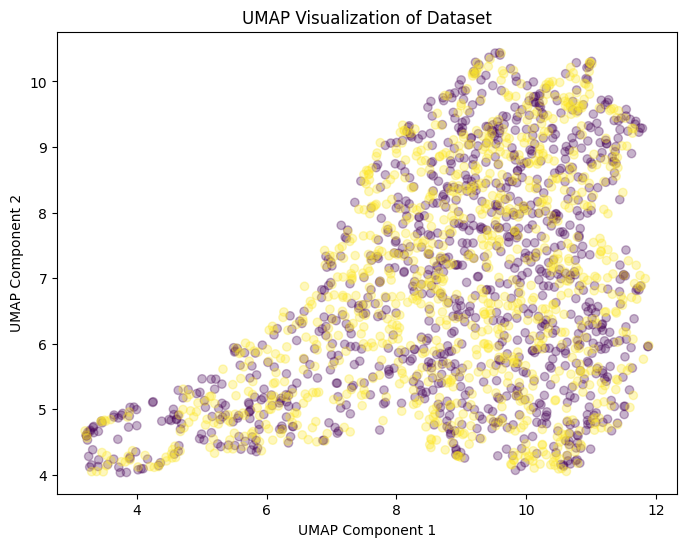

In [28]:
X_umap = UMAP().fit_transform(samples)
plt.figure(figsize=(8, 6))
plt.scatter(X_umap[:, 0], X_umap[:, 1], c=labels, alpha=0.3)
plt.title('UMAP Visualization of Dataset')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.show()

In [228]:
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(samples)

Text(0, 0.5, 't-SNE Component 2')

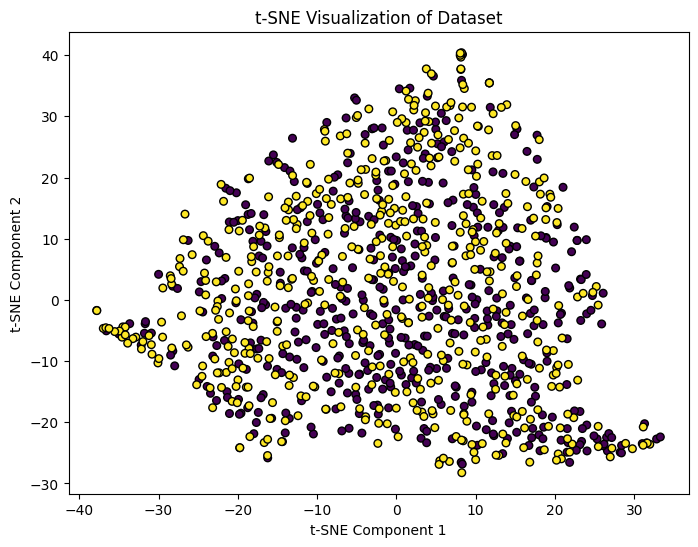

In [229]:
plt.figure(figsize=(8, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels, cmap='viridis', edgecolors='k', s=30)
plt.title('t-SNE Visualization of Dataset')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
# Check UMAP

In [278]:
nll_zeros = []
nll_ones = []
for x, y in test_loader:
    with torch.no_grad():
        y = torch.zeros(x.shape[0], 1)
        nll_zeros.append(flow.log_prob(x, context=y))

        y = torch.ones(x.shape[0], 1)
        nll_ones.append(flow.log_prob(x, context=y))

nll_zeros = np.hstack(nll_zeros)
nll_ones = np.hstack(nll_ones)
point_i = np.argmax(nll_zeros - nll_ones)

In [384]:
point_i = torch.randint(0, 3000, (1,)).item()

In [385]:
point_i, X_test[point_i].numpy(), y_test[point_i]

(1622,
 array([ 0.54800695,  0.5542981 , -0.19122131,  0.6744731 ,  1.1975008 ,
        -0.01700154,  0.06034066,  0.5130506 , -0.671328  ,  0.5515591 ,
         0.62700135,  1.1071882 , -0.08247692,  0.5382411 ,  0.7129019 ,
         0.04147275,  0.05961367, -0.45344234,  0.5187959 ,  0.6378917 ,
         0.7446567 , -0.00538139,  0.32193276], dtype=float32),
 tensor(0.))

In [386]:
print(f"Prob: {flow.log_prob(X_test[point_i].reshape(1, -1), torch.tensor([[0]], dtype=torch.float32)).exp().item()}, context = 0")
print(f"Prob: {flow.log_prob(X_test[point_i].reshape(1, -1), torch.tensor([[1]], dtype=torch.float32)).exp().item()}, context = 1")

Prob: 0.0002764708478935063, context = 0
Prob: 2.350864997424651e-05, context = 1


In [387]:
x_origin = torch.tensor([X_test[point_i].numpy()], requires_grad=False)
x = torch.tensor([X_test[point_i].numpy()], requires_grad=True)

def optim_function(x, x_origin, model, alpha=1.0, origin_class = 0):
    model.eval()

    if origin_class == 1:
        y_orig = torch.ones(x.shape[0]).reshape(-1, 1)
        y_hat = torch.zeros(x.shape[0]).reshape(-1, 1)
    else:
        y_orig = torch.zeros(x.shape[0]).reshape(-1, 1)
        y_hat = torch.ones(x.shape[0]).reshape(-1, 1)

    dist = torch.linalg.norm(x_origin-x, axis=1)
    
    p_orig = model.log_prob(x, context=y_orig)
    p_hat = model.log_prob(x, context=y_hat)
    
    return dist - alpha * (p_hat - torch.logsumexp(torch.concat([p_orig, p_hat]), dim=0))

In [388]:
optimizer = optim.Adam([x], lr=0.01)
alpha = 1

num_iterations = 200
for i in range(num_iterations):
    flow.train()
    y = optim_function(x, x_origin, flow, alpha=alpha, origin_class=0)
    optimizer.zero_grad()
    y.backward()
    optimizer.step()
    if (i+1) % 10 == 0:
        print(y.item())

1.8864270448684692
0.9049898982048035
0.7109176516532898
0.6691541075706482
0.5732492208480835
0.49000024795532227
0.45233210921287537
0.425648033618927
0.4055730402469635
0.39156290888786316
0.3814298212528229
0.3741246163845062
0.36920034885406494
0.36610186100006104
0.36430466175079346
0.36332646012306213
0.36283138394355774
0.3625974655151367
0.36249223351478577
0.36244940757751465


In [389]:
with torch.no_grad():
    nll_zero_context = flow.log_prob(x.reshape(1, -1), context=torch.Tensor([[0]])).exp()
    nll_one_context = flow.log_prob(x.reshape(1, -1), context=torch.Tensor([[1]])).exp()
print(f"Context 0 prob: {nll_zero_context.item()},\nContext 1 prob: {nll_one_context.item()}")

Context 0 prob: 9.247255405853139e-08,
Context 1 prob: 6.7002588366449345e-06


In [390]:
nn = NearestNeighbors(n_neighbors=10)
nn.fit(Xs)
distances, indexes = nn.kneighbors(x.detach().numpy().reshape(1, -1))
print(distances)
data.iloc[indexes.squeeze()]

[[0.34873958 1.13355631 1.20478676 1.26164916 1.30440386 1.35181711
  1.36519482 1.38486527 1.40023403 1.49032029]]


,ExternalRiskEstimate,MSinceOldestTradeOpen,MSinceMostRecentTradeOpen,AverageMInFile,NumSatisfactoryTrades,NumTrades60Ever2DerogPubRec,NumTrades90Ever2DerogPubRec,PercentTradesNeverDelq,MSinceMostRecentDelq,MaxDelq2PublicRecLast12M,...,MSinceMostRecentInqexcl7days,NumInqLast6M,NumInqLast6Mexcl7days,NetFractionRevolvingBurden,NetFractionInstallBurden,NumRevolvingTradesWBalance,NumInstallTradesWBalance,NumBank2NatlTradesWHighUtilization,PercentTradesWBalance,is_at_risk
157,0.548007,0.554298,-0.191221,0.674473,1.197501,-0.017002,0.060341,0.513051,-0.671328,0.551559,...,0.712902,0.041473,0.059614,-0.453442,0.518796,0.637892,0.744657,-0.005381,0.321933,0.0
6900,0.358619,0.709296,0.109506,0.132970,1.582007,-0.017002,0.060341,0.513051,-0.671328,0.551559,...,0.712902,0.041473,0.059614,0.045581,0.661315,0.637892,0.744657,-0.005381,0.538459,0.0
6843,0.642701,0.554298,-0.191221,0.210328,1.582007,-0.017002,0.060341,0.513051,-0.671328,0.551559,...,0.877721,-0.273077,-0.258498,-0.686320,1.183886,0.411287,0.498400,-0.005381,0.394108,0.0
4771,0.311271,0.016363,-0.116040,-0.073317,1.428204,-0.017002,0.060341,0.513051,-0.671328,0.551559,...,0.548083,0.356022,0.377726,-0.386906,0.542549,0.637892,0.744657,0.292417,0.177582,0.0
7746,0.974131,0.371947,-0.416766,0.004041,1.120600,-0.017002,0.060341,0.513051,-0.671328,0.551559,...,0.548083,0.041473,0.059614,-0.852661,1.231392,0.184681,0.744657,-0.005381,0.394108,1.0
8061,0.453313,0.809590,-0.266403,0.055613,1.351303,0.380804,0.482766,0.513051,-0.671328,0.285325,...,1.042540,-0.273077,-0.258498,-0.852661,1.112626,0.864497,0.990914,-0.005381,0.177582,0.0
9671,0.453313,0.882530,0.034324,0.416615,1.351303,-0.017002,0.060341,0.513051,-0.671328,0.551559,...,0.053626,0.041473,0.059614,0.078849,0.328770,-0.041924,0.744657,0.292417,-0.002857,1.0
9654,0.642701,-0.175106,0.410232,0.545544,1.120600,-0.017002,0.060341,0.513051,-0.671328,0.551559,...,0.383264,0.041473,0.059614,-0.885929,0.542549,0.637892,0.498400,-0.005381,-0.075032,0.0
9259,0.784743,0.025480,-0.416766,0.751831,0.889896,-0.017002,0.060341,0.513051,-0.671328,0.551559,...,0.712902,0.041473,0.059614,-0.420174,0.257511,0.184681,0.252143,0.292417,0.285845,0.0
4747,0.358619,0.454005,-0.491948,0.365043,1.582007,-0.017002,0.060341,0.513051,-0.671328,0.551559,...,0.383264,0.041473,0.059614,-0.719588,0.328770,0.411287,0.744657,-0.005381,-0.616349,0.0


In [391]:
distances, indexes = nn.kneighbors(X_test[point_i].numpy().reshape(1, -1))
print(distances)
data.iloc[indexes.squeeze()]

[[0.         1.05418344 1.1764682  1.20521097 1.31523361 1.33164377
  1.37367705 1.3817944  1.40613271 1.41683587]]


,ExternalRiskEstimate,MSinceOldestTradeOpen,MSinceMostRecentTradeOpen,AverageMInFile,NumSatisfactoryTrades,NumTrades60Ever2DerogPubRec,NumTrades90Ever2DerogPubRec,PercentTradesNeverDelq,MSinceMostRecentDelq,MaxDelq2PublicRecLast12M,...,MSinceMostRecentInqexcl7days,NumInqLast6M,NumInqLast6Mexcl7days,NetFractionRevolvingBurden,NetFractionInstallBurden,NumRevolvingTradesWBalance,NumInstallTradesWBalance,NumBank2NatlTradesWHighUtilization,PercentTradesWBalance,is_at_risk
157,0.548007,0.554298,-0.191221,0.674473,1.197501,-0.017002,0.060341,0.513051,-0.671328,0.551559,...,0.712902,0.041473,0.059614,-0.453442,0.518796,0.637892,0.744657,-0.005381,0.321933,0.0
6900,0.358619,0.709296,0.109506,0.132970,1.582007,-0.017002,0.060341,0.513051,-0.671328,0.551559,...,0.712902,0.041473,0.059614,0.045581,0.661315,0.637892,0.744657,-0.005381,0.538459,0.0
6843,0.642701,0.554298,-0.191221,0.210328,1.582007,-0.017002,0.060341,0.513051,-0.671328,0.551559,...,0.877721,-0.273077,-0.258498,-0.686320,1.183886,0.411287,0.498400,-0.005381,0.394108,0.0
4771,0.311271,0.016363,-0.116040,-0.073317,1.428204,-0.017002,0.060341,0.513051,-0.671328,0.551559,...,0.548083,0.356022,0.377726,-0.386906,0.542549,0.637892,0.744657,0.292417,0.177582,0.0
9671,0.453313,0.882530,0.034324,0.416615,1.351303,-0.017002,0.060341,0.513051,-0.671328,0.551559,...,0.053626,0.041473,0.059614,0.078849,0.328770,-0.041924,0.744657,0.292417,-0.002857,1.0
7746,0.974131,0.371947,-0.416766,0.004041,1.120600,-0.017002,0.060341,0.513051,-0.671328,0.551559,...,0.548083,0.041473,0.059614,-0.852661,1.231392,0.184681,0.744657,-0.005381,0.394108,1.0
9654,0.642701,-0.175106,0.410232,0.545544,1.120600,-0.017002,0.060341,0.513051,-0.671328,0.551559,...,0.383264,0.041473,0.059614,-0.885929,0.542549,0.637892,0.498400,-0.005381,-0.075032,0.0
8061,0.453313,0.809590,-0.266403,0.055613,1.351303,0.380804,0.482766,0.513051,-0.671328,0.285325,...,1.042540,-0.273077,-0.258498,-0.852661,1.112626,0.864497,0.990914,-0.005381,0.177582,0.0
9259,0.784743,0.025480,-0.416766,0.751831,0.889896,-0.017002,0.060341,0.513051,-0.671328,0.551559,...,0.712902,0.041473,0.059614,-0.420174,0.257511,0.184681,0.252143,0.292417,0.285845,0.0
4747,0.358619,0.454005,-0.491948,0.365043,1.582007,-0.017002,0.060341,0.513051,-0.671328,0.551559,...,0.383264,0.041473,0.059614,-0.719588,0.328770,0.411287,0.744657,-0.005381,-0.616349,0.0
